# Project 3: Deepening the Analysis — Income, HIV Rates, and Borough Differences in NYC

## Prompt

- **Dataset(s) to be used:**
  - NYC ACS 5-year ZIP Code Median Household Income (2018–2022)
  - NYC DOHMH HIV Surveillance Data (New Diagnosis Rate by UHF Neighborhood and Year)

- **Analysis question:**
  How strongly is neighborhood-level income associated with HIV new diagnosis rates in NYC? 
  Does this relationship vary across boroughs and over time?

- **Columns that will be used:**
  - Income dataset: `GEO_ID`, `NAME`, `B19013_001E`, `year`
  - ZIP–UHF crosswalk: `zipcode`, `neighborhood`
  - HIV dataset: `neighborhood`, `year`, `borough`, `hiv_rate`

- **Merge keys:**
  - Income → ZIP crosswalk on `zipcode`
  - After aggregation → merge with HIV on `neighborhood`, `year`

- **Hypothesis:**
  Higher‐income neighborhoods tend to have lower HIV diagnosis rates, 
  but the strength of the relationship differs across boroughs and is not stable over time.


## Load Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load and Clean Income Data

In [9]:
income_files = {
    2018: "ACSDT5Y2018.B19013-Data.csv",
    2019: "ACSDT5Y2019.B19013-Data.csv",
    2020: "ACSDT5Y2020.B19013-Data.csv",
    2021: "ACSDT5Y2021.B19013-Data.csv",
    2022: "ACSDT5Y2022.B19013-Data.csv",
}

dfs = []

for year, file in income_files.items():
    df = pd.read_csv(file)
    df["year"] = year
    dfs.append(df)

income_all = pd.concat(dfs, ignore_index=True)

income_all = income_all.rename(columns={
    "GEO_ID": "geography",
    "NAME": "name",
    "B19013_001E": "median_income"
})

income_all = income_all[["name", "median_income", "year"]]

income_all["zipcode"] = income_all["name"].str.replace(r"ZCTA5\s+", "", regex=True)
income_all["zipcode"] = income_all["zipcode"].astype(str)
income_all["median_income"] = pd.to_numeric(income_all["median_income"], errors="coerce")

income_all.head()



,name,median_income,year,zipcode
0,Geographic Area Name,NaN,2018,Geographic Area Name
1,ZCTA5 00601,13092.0,2018,00601
2,ZCTA5 00602,16358.0,2018,00602
3,ZCTA5 00603,16603.0,2018,00603
4,ZCTA5 00606,12832.0,2018,00606


## Compute Income Data to Neighborhood-Level

In [10]:
zip_uhf = pd.DataFrame({
    "zipcode": [
        "10463", "10471", 
        "10466", "10469", "10470", "10475", 
        "10458", "10467", "10468", 
        "10461", "10462", "10464", "10465", "10472", "10473", 
        "10453", "10457", "10460",
        "10451", "10452", "10456", 
        "10454", "10455", "10459", "10474", 
        "11211", "11222", 
        "11201", "11205", "11215", "11217", "11231", 
        "11213", "11212", "11216", "11233", "11238", 
        "11207", "11208", 
        "11220", "11232", 
        "11204", "11218", "11219", "11230", 
        "11203", "11210", "11225", "11226", 
        "11234", "11236", "11239", 
        "11209", "11214", "11228", 
        "11223", "11224", "11229", "11235", 
        "11206", "11221", "11237",
        "10031", "10032", "10033", "10034", "10040", 
        "10026", "10027", "10030", "10037", "10039", 
        "10029", "10035",
        "10023", "10024", "10025",
        "10021", "10028", "10044", "10128",
        "10001", "10011", "10118", "10019", "10020", "10036",
        "10010", "10016", "10017", "10022", 
        "10012", "10013", "10014", 
        "10002", "10003", "10009", 
        "10004", "10005", "10006", "10007", "10038", "10280", 
        "11101", "11102", "11103", "11104", "11105", "11106", 
        "11368", "11369", "11370", "11372", "11373", "11377", "11378", 
        "11354", "11355", "11356", "11357", "11358", "11359", "11360", 
        "11361", "11362", "11363", "11364",
        "11374", "11375", "11379", "11385", 
        "11365", "11366", "11367",
        "11414", "11415", "11416", "11417", "11418", "11419", "11420", "11421", 
        "11412", "11423", "11432", "11433", "11434", "11435", "11436",
        "11004", "11005", "11411", "11413", "11422", "11426", "11427", "11428", "11429", 
        "11691", "11692", "11693", "11694", "11695", "11697", 
        "10302", "10303", "10310",
        "10301", "10304", "10305",
        "10314",
        "10306", "10307", "10308", "10309", "10312"
    ],
    "uhf_neighborhood": [
        "Kingsbridge - Riverdale", "Kingsbridge - Riverdale", 
        "Northeast Bronx", "Northeast Bronx", "Northeast Bronx", "Northeast Bronx",
        "Fordham - Bronx Park", "Fordham - Bronx Park", "Fordham - Bronx Park",
        "Pelham - Throgs Neck",  "Pelham - Throgs Neck",  "Pelham - Throgs Neck", "Pelham - Throgs Neck", "Pelham - Throgs Neck", "Pelham - Throgs Neck", 
        "Crotona - Tremont", "Crotona - Tremont", "Crotona - Tremont",
        "High Bridge - Morrisania", "High Bridge - Morrisania", "High Bridge - Morrisania",
        "Hunts Point - Mott Haven", "Hunts Point - Mott Haven", "Hunts Point - Mott Haven", "Hunts Point - Mott Haven",
        "Greenpoint", "Greenpoint",
        "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope",
        "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights",
        "East New York", "East New York",
        "Sunset Park", "Sunset Park",
        "Borough Park", "Borough Park", "Borough Park", "Borough Park",
        "East Flatbush - Flatbush", "East Flatbush - Flatbush", "East Flatbush - Flatbush", "East Flatbush - Flatbush",
        "Canarsie - Flatlands", "Canarsie - Flatlands", "Canarsie - Flatlands",
        "Bensonhurst - Bay Ridge", "Bensonhurst - Bay Ridge", "Bensonhurst - Bay Ridge",
        "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay",
        "Williamsburg - Bushwick", "Williamsburg - Bushwick", "Williamsburg - Bushwick",
        "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood",
        "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights",
        "East Harlem", "East Harlem",
        "Upper West Side", "Upper West Side", "Upper West Side",
        "Upper East Side", "Upper East Side", "Upper East Side", "Upper East Side",
        "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton",
        "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill",
        "Greenwich Village - SoHo", "Greenwich Village - SoHo", "Greenwich Village - SoHo",
        "Union Square - Lower East Side", "Union Square - Lower East Side", "Union Square - Lower East Side",
        "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan",
        "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria",
        "West Queens", "West Queens", "West Queens", "West Queens", "West Queens", "West Queens", "West Queens",
        "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", 
        "Bayside - Little Neck", "Bayside - Little Neck", "Bayside - Little Neck", "Bayside - Little Neck",
        "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", 
        "Fresh Meadows", "Fresh Meadows", "Fresh Meadows", 
        "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", 
        "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", 
        "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens",
        "Rockaway", "Rockaway", "Rockaway", "Rockaway", "Rockaway", "Rockaway",
        "Port Richmond", "Port Richmond", "Port Richmond",
        "Stapleton - St. George", "Stapleton - St. George", "Stapleton - St. George",
        "Willowbrook",
        "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville"
    ]
})

# make sure zipcode is string
zip_uhf["zipcode"] = zip_uhf["zipcode"].astype(str)

# drop any old neighborhood columns so we don't get duplicates
cols_to_drop = [c for c in income_all.columns if "neighborhood" in c]
income_all = income_all.drop(columns=cols_to_drop, errors="ignore")

# merge zip -> UHF neighborhood
income_all = income_all.merge(zip_uhf, on="zipcode", how="left")
income_all = income_all.rename(columns={"uhf_neighborhood": "neighborhood"})

# keep only rows with a matched neighborhood and needed columns
income_neighborhood = income_all[income_all["neighborhood"].notna()].copy()
income_neighborhood = income_neighborhood[["median_income", "year", "zipcode", "neighborhood"]]

# average median income by neighborhood-year
neighborhood_income = (
    income_neighborhood
    .groupby(["neighborhood", "year"], as_index=False)
    .agg(avg_median_income=("median_income", "mean"))
)

neighborhood_income.head()



,neighborhood,year,avg_median_income
0,Bayside - Little Neck,2018,89213.00
1,Bayside - Little Neck,2019,91068.00
2,Bayside - Little Neck,2020,94246.50
3,Bayside - Little Neck,2021,95835.75
4,Bayside - Little Neck,2022,107308.25


## Load HIV Surveillance Data

In [11]:
hiv = pd.read_csv("hiv_joined.csv")
hiv.head()

,year,borough,neighborhood,hiv_rate
0,2016,Bronx,Crotona - Tremont,42.826667
1,2016,Bronx,Fordham - Bronx Park,35.280000
2,2016,Bronx,High Bridge - Morrisania,42.460000
3,2016,Bronx,Hunts Point - Mott Haven,73.600000
4,2016,Bronx,Kingsbridge - Riverdale,20.100000


## Checking Neighborhood Consistency

In [12]:
set_income = set(neighborhood_income["neighborhood"].unique())
set_hiv = set(hiv["neighborhood"].unique())

print("HIV not in income:", set_hiv - set_income)
print("Income not in HIV:", set_income - set_hiv)

HIV not in income: set()
Income not in HIV: set()


## Merge Income and HIV Datasets

In [14]:
merged = neighborhood_income.merge(
    hiv,
    on=["neighborhood", "year"],
    how="inner"
)

merged.head()

,neighborhood,year,avg_median_income,borough,hiv_rate
0,Bayside - Little Neck,2018,89213.00,Queens,2.440000
1,Bayside - Little Neck,2019,91068.00,Queens,2.173333
2,Bayside - Little Neck,2020,94246.50,Queens,0.000000
3,Bayside - Little Neck,2021,95835.75,Queens,0.000000
4,Bedford Stuyvesant - Crown Heights,2018,50985.20,Brooklyn,32.433333


## Relationship Between Income and HIV New Diagnosis Rates (Citywide)

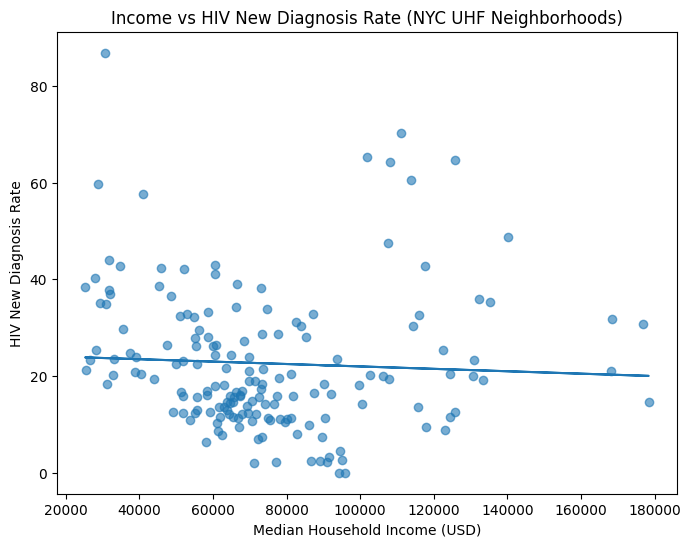

In [15]:
plt.figure(figsize=(8, 6))

x = merged["avg_median_income"]
y = merged["hiv_rate"]

plt.scatter(x, y, alpha=0.6)

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b)

plt.xlabel("Median Household Income (USD)")
plt.ylabel("HIV New Diagnosis Rate")
plt.title("Income vs HIV New Diagnosis Rate (NYC UHF Neighborhoods)")

plt.show()


In [21]:
from scipy.stats import pearsonr

# Compute citywide correlation and p-value
r_city, p_city = pearsonr(merged["avg_median_income"], merged["hiv_rate"])

citywide_stats = pd.DataFrame({
    "correlation_r": [r_city],
    "p_value": [p_city]
})

citywide_stats

,correlation_r,p_value
0,-0.052386,0.50006


### Statistical Significance of the Citywide Relationship

To assess whether the weak negative trend in the citywide scatterplot reflects a meaningful linear relationship, I computed the Pearson correlation coefficient and its associated p-value.

The correlation is **r = -0.052**, and the corresponding **p-value = 0.500**.

This very high p-value indicates that the relationship is **not statistically significant** at any conventional threshold (e.g., 0.05). In statistical terms, we cannot reject the null hypothesis that the true correlation between income and HIV new diagnosis rates is zero.

Combined with the nearly horizontal trendline, this suggests that income alone provides almost no explanatory power for HIV diagnosis patterns at the citywide level. The weak negative association observed visually is consistent with random variation rather than a systematic effect.

These results further motivate examining the relationship within boroughs, where structural and demographic differences may produce clearer patterns.

## Does the Relationship Differ Across Boroughs?

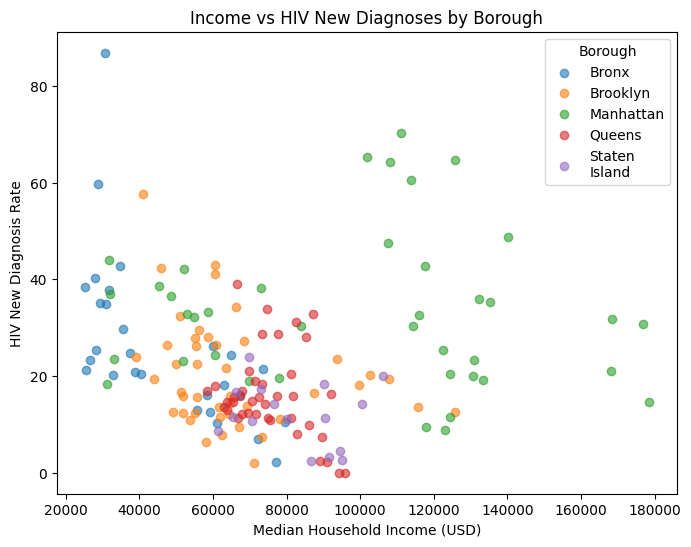

In [16]:
plt.figure(figsize=(8, 6))

for borough, subset in merged.groupby("borough"):
    plt.scatter(
        subset["avg_median_income"],
        subset["hiv_rate"],
        alpha=0.6,
        label=borough
    )

plt.xlabel("Median Household Income (USD)")
plt.ylabel("HIV New Diagnosis Rate")
plt.title("Income vs HIV New Diagnoses by Borough")
plt.legend(title="Borough")

plt.show()


In [20]:
from scipy.stats import pearsonr

results = []

for borough, subset in merged.groupby("borough"):
    r, p = pearsonr(subset["avg_median_income"], subset["hiv_rate"])
    results.append({
        "borough": borough,
        "correlation_r": r,
        "p_value": p
    })

borough_pvals = pd.DataFrame(results)
borough_pvals

,borough,correlation_r,p_value
0,Bronx,-0.624261,0.000385
1,Brooklyn,-0.288806,0.057262
2,Manhattan,-0.056443,0.729394
3,Queens,-0.272005,0.089518
4,Staten\nIsland,-0.188940,0.483424


### Borough-Level Interpretation

Across boroughs, the strength and significance of the income–HIV relationship vary notably.  
Only the **Bronx** shows a **strong and statistically significant** negative correlation, suggesting that higher-income neighborhoods tend to have substantially lower HIV diagnosis rates. **Brooklyn** and **Queens** exhibit weaker, marginally significant negative relationships, while **Manhattan** and **Staten Island** show no meaningful association, indicating that income is not a key predictor of HIV outcomes in those areas.

## Overall Research Takeaway

Citywide, median household income shows **no statistically significant relationship** with HIV new diagnosis rates. The weak overall correlation appears to be driven by the strong negative association in the Bronx rather than a consistent pattern across NYC. This suggests that HIV outcomes are influenced less by income alone and more by borough-specific structural and contextual factors, such as access to healthcare, demographic differences, and long-standing neighborhood disparities.